In [1]:
import pandas as pd
import numpy as np

# Deep learning
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

# NLP imports
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# evaluate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# misc imports
from ast import literal_eval
import glob
import pickle

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Provide root path to dataset
dataset_root = '/content/drive/MyDrive/UMich Milestone II Project/Final_Code_Submission/Dataset/'

# RNN

Reference:

1. SIADS 642: Deep Learning Notebooks (https://www.coursera.org/learn/siads642/home/week/3)
2. https://zhoubeiqi.medium.com/named-entity-recognition-ner-using-keras-lstm-spacy-da3ea63d24c5
3. https://web.archive.org/web/20211110115049/http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
4. https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
5.  Regularization - https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9

NER using RNN

1. Vectorize input sentence (maybe a vector representing each word and sentence is a list of vectors?)
2. RNN will classify each word into either: food, drink, None
3. TO DO: Use bi dir LSTM

### Data Pre processing

In [4]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Get all NER datasets in root directory
file_list = glob.glob(dataset_root + '/NER/Yelp/yelp_NER_sample_*.csv')

dfs = []
for file in file_list:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
reviews_df = pd.concat(dfs, ignore_index=True)

# Drop reviews with missing annotations
reviews_df = reviews_df.dropna(subset=['ner_results'])

In [6]:
# Add Kaggle validation dataset
file_list = glob.glob(dataset_root + '/NER/Kaggle/kaggle_subsample_*.csv')

dfs = []
for file in file_list:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
val_reviews_df = pd.concat(dfs, ignore_index=True)
# filter relevant columns
val_reviews_df = val_reviews_df[['Restaurant', 'Review', 'Rating', 'ner_results']]
# Drop reviews with missing annotations
val_reviews_df = val_reviews_df.dropna(subset=['ner_results', 'Review'])
val_reviews_df.head()

,Restaurant,Review,Rating,ner_results
0,PourHouse7,Pocket-friendly place for a quick round of dri...,3.0,"{'food': ['Chicken', 'Fish', 'veg'], 'drink': ..."
1,PourHouse7,Visited the clubbing section of the resturant ...,5.0,"{'food': ['Chinken Nazakat', 'butter garlic pr..."
2,PourHouse7,Went for a friend’s birthday celebration. The ...,4.0,"{'food': ['veg white sauce pasta', 'biryani'],..."
4,PourHouse7,Ambience was great.. food was good too.. servi...,5.0,"{'food': ['food was good too'], 'drink': ['dri..."
5,PourHouse7,"Loud music, average food and untrained staff s...",2.0,"{'food': ['veg hakka noodle', 'special pizza']..."


In [7]:
# Function to convert text into (word, pos_tag, ner_label) tuples
def convert_text_to_tuples(text, ner_results):

    # print(f"review: {text}")
    # print(f"NER: {ner_results}")

    # lowercasing text
    text = text.lower()
    # Tokenize the text
    words = word_tokenize(text, language='english')
    # removing punctuation
    words = [word for word in words if word not in string.punctuation]

    # stop word removal
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]


    # Get POS tags for the words
    pos_tags = pos_tag(words)

    # Initialize list to store (word, pos_tag, ner_label) tuples
    word_tuples = []

    # Convert ner_results from string to dictionary
    ner_results_dict = literal_eval(ner_results)
    if type(ner_results_dict) != dict:
        print(f"caught unexpected NER type: {ner_results}")
        return word_tuples

    # Check only ('food', 'drink', 'None') exist in NER lables
    valid_NER_Lables = ['food', 'drink', 'None']
    for lable in ner_results_dict.keys():
        if lable not in valid_NER_Lables:
            # print(ner_results_dict)
            return word_tuples

    # Iterate through words and POS tags
    i = 0
    while i < len(words):
        # Check if the word is a named entity (food/drink item)
        ner_label = None
        for label, entities in ner_results_dict.items():
            # catch unexpected NER entities
            try:
                # lower case valid food/drink terms for word match
                entities_lower = [item.lower() for item in entities]
            except:
                print(f"caught unexpected NER: {ner_results}")
                return word_tuples

            # loop through each valid food/drink item
            for food_drink_item in entities:
                # check if given word is part of food/drink item
                possible_food_drink = ' '.join(words[i:i+len(food_drink_item.split())]).lower()
                # print(f"possible food/drink: {possible_food_drink}")
                if possible_food_drink in entities_lower:
                    # print(f"found a match {possible_food_drink}")
                    match_food_drink = possible_food_drink.split()
                    ner_label = label
                    # Add (word, pos_tag, ner_label) tuple for each word in the named entity
                    for j in range(len(match_food_drink)):
                        word_tuples.append((words[i+j], pos_tags[i+j][1], ner_label))
                    i += len(match_food_drink) - 1  # Skip the next words as they are part of the named entity
                    break
        if ner_label is None:
            # If not a named entity, add (word, pos_tag, None) tuple
            word_tuples.append((words[i], pos_tags[i][1], 'None'))
        i += 1
    return word_tuples


In [8]:
# Apply the function to each review
reviews_df['word_tuples'] = reviews_df.apply(lambda row: convert_text_to_tuples(row['text'], row['ner_results']), axis=1)

# remove empty word tuples
reviews_df = reviews_df[reviews_df['word_tuples'].apply(lambda x: len(x) != 0)]

caught unexpected NER type: [{'type': 'food', 'name': 'Mac n cheese'}, {'type': 'drink', 'name': 'beer'}]
caught unexpected NER: {'food': [{'item': 'Tuna Tartare', 'rating': 4.5}, {'item': 'Spinach and Asparagus', 'rating': 4.5}, {'item': 'Chilean Sea Bass', 'rating': 4.5}, {'item': 'Crab Cake', 'rating': 4.5}], 'drink': []}
caught unexpected NER: {'food': [{'name': 'Lynchburg Basil Lemonade', 'description': 'Jack Daniels, Fresh Basil, Homemade Southern Lemonade'}, {'name': 'Black Cherry Gimlet', 'description': 'Black Cherry Vodka, Vanilla, Lime, maraschino Cherry'}], 'drink': [{'name': 'Lynchburg Basil Lemonade', 'description': 'Jack Daniels, Fresh Basil, Homemade Southern Lemonade'}, {'name': 'Black Cherry Gimlet', 'description': 'Black Cherry Vodka, Vanilla, Lime, maraschino Cherry'}]}
caught unexpected NER: {'food': [{'name': 'Foie Gras Soup', 'description': 'Perfect combination of richness and spice, and just awesome.', 'rating': 5}, {'name': 'Pork Belly in Chili Oil', 'descriptio

In [9]:
# Apply above to validation set!
val_reviews_df['word_tuples'] = val_reviews_df.apply(lambda row: convert_text_to_tuples(row['Review'], row['ner_results']), axis=1)

# remove empty word tuples
val_reviews_df = val_reviews_df[val_reviews_df['word_tuples'].apply(lambda x: len(x) != 0)]


### Feature Engineering

In [10]:
unique_words = set()
unique_tags = set()
for list_word_tuple in reviews_df['word_tuples']:
    for word_tuple in list_word_tuple:
        word, _, tag = word_tuple
        unique_words.add(word)
        unique_tags.add(tag)

In [11]:
# apply abobe to validation set!
for list_word_tuple in val_reviews_df['word_tuples']:
    for word_tuple in list_word_tuple:
        word, _, tag = word_tuple
        unique_words.add(word)
        unique_tags.add(tag)

In [12]:
words = list(unique_words)
words.append("ENDPAD")
NUM_WORDS = len(words)
print("Unique words in corpus:", NUM_WORDS)

tags = list(unique_tags)
NUM_TAGS = len(tags)
print("Unique tags in corpus:", NUM_TAGS)

Unique words in corpus: 45049
Unique tags in corpus: 3


In [13]:
# TO DO: Plot histogram of tag/class distribution in train and test set
# import plotly.express as px
#fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
#fig.show()

In [14]:
# generate dict of indx : word/tag
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# create reverse lookup
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}

# Save above dicts for embedding train, test, validation set outside of this notebook
with open(dataset_root + '/NER/Model/word2idx.pickle', 'wb') as f:
    pickle.dump(word2idx, f)

with open(dataset_root + '/NER/Model/tag2idx.pickle', 'wb') as f:
    pickle.dump(tag2idx, f)

with open(dataset_root + '/NER/Model/idx2word.pickle', 'wb') as f:
    pickle.dump(idx2word, f)

with open(dataset_root + '/NER/Model/idx2tag.pickle', 'wb') as f:
    pickle.dump(idx2tag, f)

In [15]:
# Get reviews in only (word, pos_tag, ner_tag) format from train/test set only
reviews_text = reviews_df['word_tuples'].values


Max Review length: 538


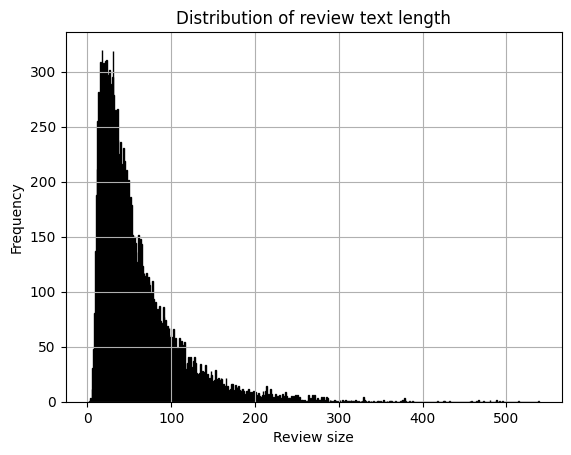

In [16]:
# Plot distribution of review text length in test/train

review_sizes = [len(review) for review in reviews_text]
print(f"Max Review length: {max(review_sizes)}")

# plot histogram
plt.hist(review_sizes, bins=range(1, max(review_sizes) + 2), color='skyblue', edgecolor='black')
plt.xlabel('Review size')
plt.ylabel('Frequency')
plt.title('Distribution of review text length')
plt.grid(True)
plt.show()

In [17]:
# Convert words to indices for X
X_var = [[word2idx[w[0]] for w in s] for s in reviews_text]
# Pad sequences for X and convert data to PyTorch tensors
X_padded = pad_sequence([torch.as_tensor(x) for x in X_var], batch_first=True, padding_value=word2idx['ENDPAD'])

# Convert tags to indices for y
y_var = [[tag2idx[w[2]] for w in s] for s in reviews_text]
# Pad sequences for y and convert data to PyTorch tensors
y_padded = pad_sequence([torch.as_tensor(y) for y in y_var], batch_first=True, padding_value=tag2idx["None"])


In [18]:
# Select a review
REV_IDX = 67

review_now = []
for word_id in X_padded[REV_IDX]:
    idx = word_id.item()
    review_now.append(idx2word[idx])
print(" ".join(review_now))
print("extracted NER:")

for i, tag_id in enumerate(y_padded[REV_IDX]):
    idx = tag_id.item()
    tag = idx2tag[idx]
    if tag in ['food', 'drink']:
        word_ind = X_padded[REV_IDX][i].item()
        print(f"found food/drink: {idx2word[word_ind]}")

great growd opinion especially late hours hit miss 'll rude food tasted good makes feel like shit appears dirty ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD

In [19]:
# split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42, shuffle=True)

# TO DO: test with stratify later to account for class imbalance?
# x_train, x_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42, shuffle=True, stratify=y_padded)

print(f"Total dataset size: {len(X_padded)}")
print(f"Train set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

Total dataset size: 18748
Train set size: 14998
Test set size: 3750


In [20]:
# batch size
batch_size = 32

# define dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


### LSTM Model

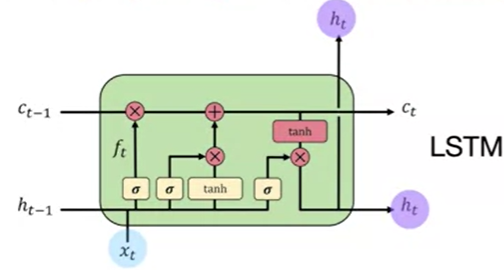

In [21]:
class NER_LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=128, hidden_dim=100, dropout=0.1):
        super(NER_LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # create embeddings (vector representations for each word in text)
        # of dimesion: embedding_dim for num_words words a.k.a input_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # dropout layer during training
        self.dropout = nn.Dropout(p=dropout)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # sentence shape: [sentence_length, batch_size]
        embedded = self.dropout(self.embedding(text))

        # LSTM input shape should be (sequence_length, batch_size, input_size)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        #print(f"hidden layer shape: {hidden.shape}")
        #print(f"lstm_out layer shape: {lstm_out.shape}")
        #print(f"hidden 0 layer shape: {hidden[0].shape}")

        # Fully connected layer
        # predictions = self.linear(self.dropout(lstm_out))
        predictions = self.linear(lstm_out)

        return predictions

In [22]:
# get iterator over train set
# batch_data, batch_target = next(iter(train_loader))

### Training

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
# Create the model
model = NER_LSTM(input_dim = NUM_WORDS, output_dim = NUM_TAGS, dropout = 0.4)

# Print the model architecture
print(model)

model.to(device)

NER_LSTM(
  (embedding): Embedding(45049, 128)
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(128, 100, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NER_LSTM(
  (embedding): Embedding(45049, 128)
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(128, 100, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [25]:
# Helper Methods

def batchPerfScore(preds, targets):

    # convert from list of tensors to torch.Tensor
    preds = torch.cat(preds, 0)
    targets = torch.cat(targets, 0)

    # print(f"shape of predictions: {preds.shape}")
    # print(f"shape of targets: {targets.shape}")

    # Reshape targets to [batch_size * sequence_length]
    targets = targets.view(-1)

    # Reshape predictions to [batch_size * sequence_length, num_classes]
    preds = preds.view(-1, NUM_TAGS)
    # get class with highest probability
    preds_softmax = torch.log_softmax(preds, dim = 1)
    pred_tags = torch.argmax(preds_softmax, dim = 1)

    # convert from tensor to numpy array type
    y_pred = pred_tags.cpu().numpy()
    y_true = targets.cpu().numpy()

    # metric multi-class classification
    return classification_report(y_true, y_pred, output_dict=True)

In [26]:
torch.manual_seed(0)

# Train Params
numEpochs = 51
learning_rate =  1e-4
weight_decay = 1e-5

# Loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [27]:
# record loss, performance metrics
loss_list=[]
train_metric_epochs = []
test_metric_epochs = []

# Train !!!
for epoch in range(numEpochs):
    # Train the model
    model.train()

    epochLoss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # transfer dataset into either CPU/GPU
        batch_text = inputs.to(device)
        batch_tags = labels.to(device)

        # Make predictions
        predictions = model(batch_text)

        # Reshape targets to [batch_size * sequence_length]
        batch_tags = batch_tags.view(-1)
        # Reshape predictions to [batch_size * sequence_length, num_classes]
        predictions = predictions.view(-1, NUM_TAGS)
        # compute loss
        loss = criterion(predictions, batch_tags)

        loss.backward()
        optimizer.step()
        epochLoss += loss.item()

    print(f'Epoch: {epoch + 1}, Train Loss: {epochLoss / len(train_loader)}')
    loss_list.append(epochLoss/len(train_loader))

    # eval model
    model.eval()

    # Compute F1 score on train set
    train_preds = []
    train_targets = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            # transfer dataset into either CPU/GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Make predictions
            outputs = model(inputs)
            train_preds.extend(outputs)
            train_targets.extend(labels)

        train_f1 = batchPerfScore(train_preds, train_targets)
        train_metric_epochs.append(train_f1)

    if epoch % 5 == 0:
        # Compute F1 score on test set
        test_preds = []
        test_targets = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                # transfer dataset into either CPU/GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Make predictions
                outputs = model(inputs)
                test_preds.extend(outputs)
                test_targets.extend(labels)

            test_f1 = batchPerfScore(test_preds, test_targets)
            test_metric_epochs.append(test_f1)

            print(f"Epoch {epoch+1}: Train Score = {train_f1}, Test Score = {test_f1}")


Epoch: 1, Train Loss: 0.18491431411458994
Epoch 1: Train Score = {'0': {'precision': 0.002673002673002673, 'recall': 0.000906070673512534, 'f1-score': 0.0013533834586466167, 'support': 9933}, '1': {'precision': 0.07967032967032966, 'recall': 0.005197784668327568, 'f1-score': 0.009758888159776555, 'support': 55793}, '2': {'precision': 0.991919043572391, 'recall': 0.9991966961207257, 'f1-score': 0.9955445697089625, 'support': 8003198}, 'accuracy': 0.9910947234104572, 'macro avg': {'precision': 0.35808745863857444, 'recall': 0.3351001838208552, 'f1-score': 0.33555228044246194, 'support': 8068924}, 'weighted avg': {'precision': 0.9843934709658091, 'recall': 0.9910947234104572, 'f1-score': 0.9875044342976366, 'support': 8068924}}, Test Score = {'0': {'precision': 0.001160092807424594, 'recall': 0.00041597337770382697, 'f1-score': 0.000612369871402327, 'support': 2404}, '1': {'precision': 0.07567567567567568, 'recall': 0.0050923905136039576, 'f1-score': 0.009542635130529617, 'support': 13746

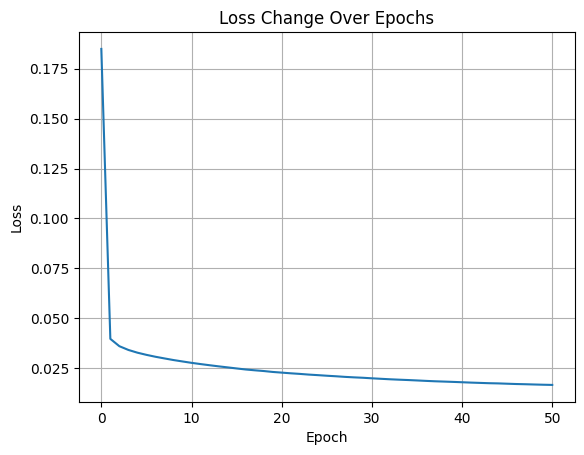

In [28]:
# Plot the loss change over epochs
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Change Over Epochs')
plt.grid(True)
plt.show()

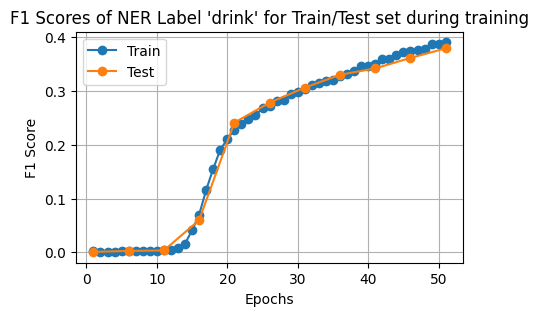

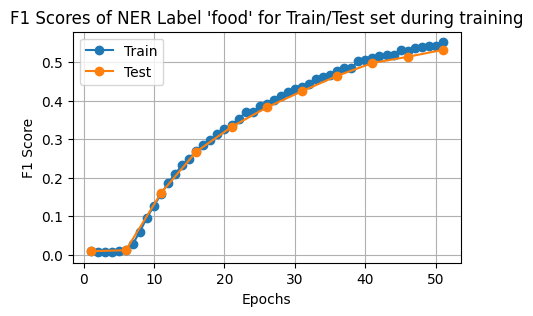

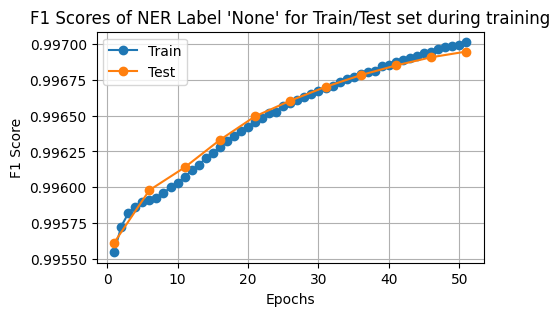

In [29]:
# plot train/test eval plots per class
for label, idx in tag2idx.items():
    # test points
    test_f1 = []
    for point in test_metric_epochs:
        test_f1.append(point[str(idx)]['f1-score'])

    # train points
    train_f1 = []
    for point in train_metric_epochs:
        train_f1.append(point[str(idx)]['f1-score'])

    # Plot the F1 scores
    plt.figure(figsize=(5, 3))
    epochs = range(1, len(train_f1) + 1)
    plt.plot(epochs, train_f1, label='Train', marker='o')
    epochs = range(1, len(test_f1) * 5, 5)
    plt.plot(epochs, test_f1, label='Test', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title(f"F1 Scores of NER Label '{label}' for Train/Test set during training")
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
# save the LSTM model

torch.save(model.state_dict(), dataset_root + '/NER/Model/model.pth')
torch.save(model, dataset_root + '/NER/Model/entire_model.pt')

### Evaluation

In [31]:
# Evaluate with test data
ner_pred_labels = []
ner_truth_labels = []

def batchAccuracy(predictions, targets):

    # Reshape targets to [batch_size * sequence_length]
    targets = targets.view(-1)
    # Reshape predictions to [batch_size * sequence_length, num_classes]
    predictions = predictions.view(-1, NUM_TAGS)

    # get NER class with highest probability
    preds_softmax = torch.log_softmax(predictions, dim = 1)
    pred_tags = torch.argmax(preds_softmax, dim = 1)

    # record predictions
    ner_pred_labels.extend(pred_tags.cpu().numpy())
    ner_truth_labels.extend(targets.cpu().numpy())

    # compute accuracy
    return (pred_tags == targets).sum().item() / len(predictions)

# set model to evaluate mode
model.eval()

with torch.no_grad():
    accuracy = 0.0
    for batch in test_loader:
        batch_text = batch[0].to(device)
        batch_tags = batch[1].to(device)

        # Make predictions
        predictions = model(batch_text)
        # compute accuracy
        acc = batchAccuracy(predictions, batch_tags)
        accuracy += acc

    print('Validation Accuracy: {}%'.format(accuracy / len(test_loader) * 100))

Validation Accuracy: 99.38380143028162%


In [32]:
print(classification_report(ner_truth_labels, ner_pred_labels, target_names = list(tag2idx.keys())))

              precision    recall  f1-score   support

       drink       0.65      0.27      0.38      2404
        food       0.68      0.44      0.53     13746
        None       1.00      1.00      1.00   2001350

    accuracy                           0.99   2017500
   macro avg       0.77      0.57      0.64   2017500
weighted avg       0.99      0.99      0.99   2017500



In [33]:
tag2idx

{'drink': 0, 'food': 1, 'None': 2}

In [34]:
# from sklearn.metrics import multilabel_confusion_matrix
# multilabel_confusion_matrix(ner_truth_labels, ner_pred_labels)
print(f"F1 score (macro avg): {f1_score(ner_truth_labels, ner_pred_labels, average='macro')}")
print(f"F1 score (micro avg): {f1_score(ner_truth_labels, ner_pred_labels, average='micro')}")
print(f"F1 score (weighted avg): {f1_score(ner_truth_labels, ner_pred_labels, average='weighted')}")
print(f"F1 score (macro avg): {f1_score(ner_truth_labels, ner_pred_labels, average=None)}")

F1 score (macro avg): 0.6362075889131108
F1 score (micro avg): 0.9938210656753408
F1 score (weighted avg): 0.9930470129230354
F1 score (macro avg): [0.37952339 0.5321498  0.99694958]


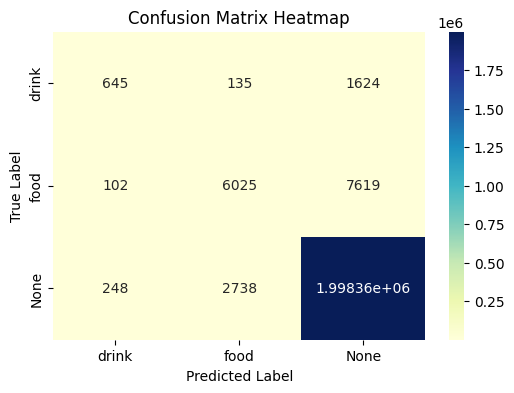

In [35]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(ner_truth_labels, ner_pred_labels)).rename(columns=idx2tag, index=idx2tag)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu", fmt='g')  # annot=True to annotate cells with the numeric value
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [36]:
confusion_matrix_df

,drink,food,None
drink,645,135,1624
food,102,6025,7619
None,248,2738,1998364
